# Convergence FEM / PINNs+Corr

In [1]:
# sélection du cas test
testcase = 1
version = 1
param_num = 1
high_degree = 10

In [2]:
assert testcase in [1,2]
if testcase == 1:
    assert version in [1,2,4]
else:
    assert version == 1

**Idée :** On se place ici dans un des cas tests proposés : TestCase1,1_v2,2.

On cherche à vérifier les convergences obtenues pour

- FEM standard
- le PINNs + Correction par addition

On choisira d'effectuer ces convergences en P1,P2 et P3

## Imports + Load

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd
import os
import dolfin as df

from scimba.equations.domain import SpaceTensor
from modfenics.solver_fem.PoissonDirSquareFEMSolver import PoissonDirSquareFEMSolver
from modfenics.utils import get_param,compute_slope
from testcases.utils import create_tree

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


Using device: cuda
cuda devices:        1
cuda current device: 0
cuda device name:    NVIDIA RTX 2000 Ada Generation Laptop GPU


In [5]:
if testcase == 1:
    if version == 1:
        from testcases.networks.test_2D.test_1.test_1_v1 import Run_laplacian2D,Poisson_2D
    elif version == 2:
        from testcases.networks.test_2D.test_1.test_1_v2 import Run_laplacian2D,Poisson_2D
    # elif version == 4:
    #     from testcases.networks.test_2D.test_1.test_1_v4 import Run_laplacian2D,Poisson_2D
    else:
        raise ValueError("Version not found")
    from testcases.problem.problem_2D import TestCase1
    problem = TestCase1(v=version)
elif testcase == 2:
    from testcases.networks.test_2D.test_2.test_2_v1 import Run_laplacian2D,Poisson_2D
    from testcases.problem.problem_2D import TestCase2
    problem = TestCase2()

result_dir = "../../../results/fenics/test_2D/testcase"+str(testcase)+"/version"+str(version)
result_dir += "/cvg/"
create_tree(result_dir)

/home/flecourtier/Bureau/Article1/code
torch loaded; device is cuda


/home/flecourtier/Bureau/Article1/code
init
init
>> load network /home/flecourtier/Bureau/Article1/code/networks/test_2D/test_fe1.pth
network loaded
Error  tensor([0.0039])


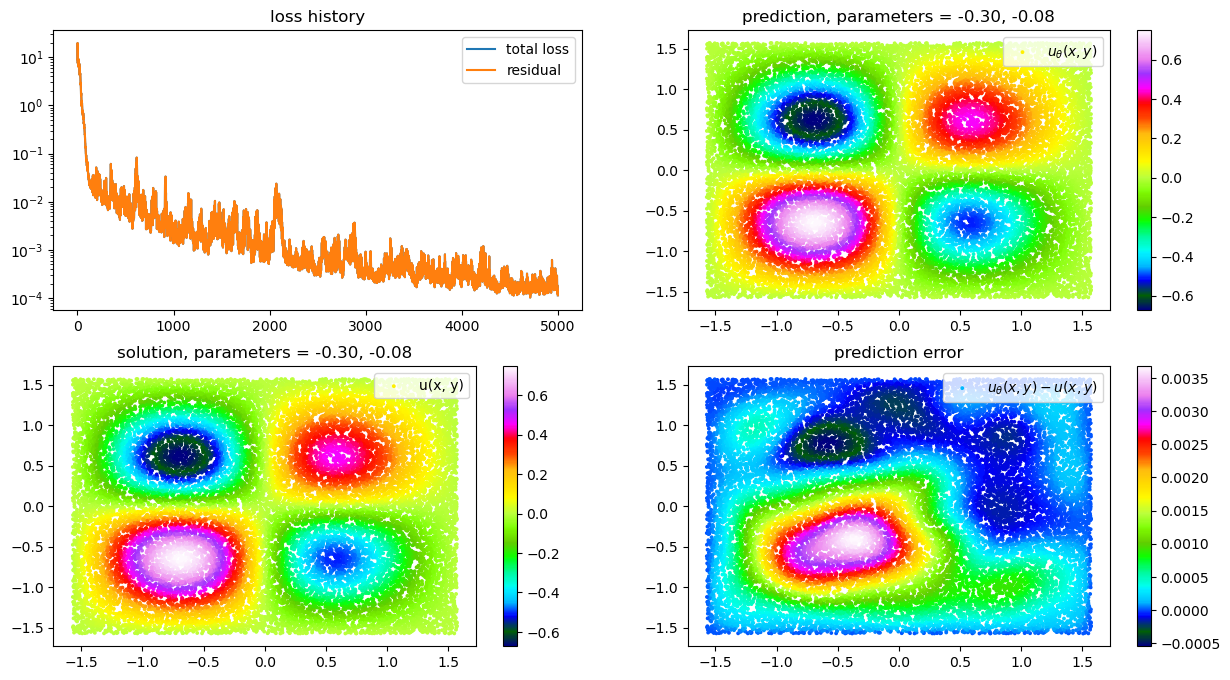

In [6]:
pde = Poisson_2D()
trainer,u_theta = Run_laplacian2D(pde)

In [7]:
param = get_param(param_num,trainer.pde.parameter_domain.cpu().numpy())
params = [param]
print(param)

[0.05 0.22]


## Convergence FEM

In [8]:
def read_csv(testcase,param_num,degree):
    df_FEM = pd.read_csv(result_dir+f'FEM_case{testcase}_param{param_num}_degree{degree}.csv')
    tab_nb_vert_FEM = list(df_FEM['nb_vert'].values)
    tab_h_FEM = list(df_FEM['h'].values)
    tab_err_FEM = list(df_FEM['err'].values)
    
    return df_FEM,tab_nb_vert_FEM, tab_h_FEM, tab_err_FEM

def run_FEM(degree,new_run=False):
    csv_file = result_dir+f'FEM_case{testcase}_param{param_num}_degree{degree}.csv'
    if not new_run and os.path.exists(csv_file):
        df_FEM,tab_nb_vert_FEM, tab_h_FEM, tab_err_FEM = read_csv(testcase,param_num,degree)
        print(f"Read csv file {csv_file}")
    else:
        tab_nb_vert_FEM = [2**i for i in range(4,9)]
        tab_h_FEM = []
        tab_err_FEM = []

        solver = PoissonDirSquareFEMSolver(params=params, problem=problem, degree=degree, high_degree=high_degree)
        for nb_vert in tab_nb_vert_FEM:
            solver.set_meshsize(nb_cell=nb_vert-1)
            tab_h_FEM.append(solver.h)
            _,norme_L2 = solver.fem(0)
            print(f"nb_vert={nb_vert}, norme_L2={norme_L2}")
            tab_err_FEM.append(norme_L2)
            
        df_FEM = pd.DataFrame({'nb_vert': tab_nb_vert_FEM, 'h': tab_h_FEM, 'err': tab_err_FEM})
        df_FEM.to_csv(csv_file, index=False)
            
    return df_FEM,tab_nb_vert_FEM, tab_h_FEM, tab_err_FEM

In [9]:
degree = 2
df_FEM, tab_nb_vert_FEM, tab_h_FEM, tab_err_FEM = run_FEM(degree)

Read csv file ../../../results/fenics/test_2D/testcase1/version1/cvg/FEM_case1_param1_degree2.csv


degree=1
Read csv file ../../../results/fenics/test_2D/testcase1/version1/cvg/FEM_case1_param1_degree1.csv
degree=2
Read csv file ../../../results/fenics/test_2D/testcase1/version1/cvg/FEM_case1_param1_degree2.csv
degree=3
Read csv file ../../../results/fenics/test_2D/testcase1/version1/cvg/FEM_case1_param1_degree3.csv


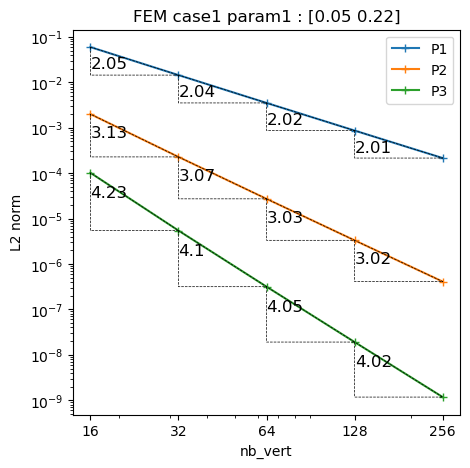

In [10]:
plt.figure(figsize=(5, 5))

# plot FEM error (L2 norm) as a function of h
for d in [1, 2, 3]:
    print(f"degree={d}")
    df_FEM, tab_nb_vert_FEM, tab_h_FEM, tab_err_FEM = run_FEM(d)
    plt.loglog(df_FEM['nb_vert'], df_FEM['err'], "+-", label='P'+str(d))
    
    for i in range(1,len(tab_nb_vert_FEM)):
        slope, vert_mid = compute_slope(i,tab_nb_vert_FEM,tab_err_FEM)
        plt.text(vert_mid[0]+1e-2 , vert_mid[1], str(slope), fontsize=12, ha='left', va='top')
    
plt.xticks(df_FEM['nb_vert'], df_FEM['nb_vert'].round(3).astype(str))
plt.xlabel('nb_vert')
plt.ylabel('L2 norm')
plt.title(f'FEM case{testcase} param{param_num} : {param}')
plt.legend()
plt.savefig(result_dir+f'FEM_case{testcase}_param{param_num}.png')

In [11]:
dict = {}
for d in [1, 2, 3]:
    print(f"degree={d}")
    _, tab_nb_vert_FEM, _, tab_err_FEM = run_FEM(d)
    if d == 1:
        dict['N'] = tab_nb_vert_FEM
    dict[f'P{d}'] = tab_err_FEM
    
df_deg = pd.DataFrame(dict)

csv_file = result_dir+f'FEM_case{testcase}_param{param_num}.csv'
df_deg.to_csv(csv_file, index=False)

degree=1
Read csv file ../../../results/fenics/test_2D/testcase1/version1/cvg/FEM_case1_param1_degree1.csv
degree=2
Read csv file ../../../results/fenics/test_2D/testcase1/version1/cvg/FEM_case1_param1_degree2.csv
degree=3
Read csv file ../../../results/fenics/test_2D/testcase1/version1/cvg/FEM_case1_param1_degree3.csv


## Convergence PINNs+Corr

In [8]:
def read_csv_Corr(testcase,param_num,degree):
    df_Corr = pd.read_csv(result_dir+f'Corr_case{testcase}_param{param_num}_degree{degree}.csv')
    tab_nb_vert_Corr = list(df_Corr['nb_vert'].values)
    tab_h_Corr = list(df_Corr['h'].values)
    tab_err_Corr = list(df_Corr['err'].values)
    
    return df_Corr,tab_nb_vert_Corr, tab_h_Corr, tab_err_Corr

def run_Corr(degree,new_run=False):
    csv_file = result_dir+f'Corr_case{testcase}_param{param_num}_degree{degree}.csv'
    if not new_run and os.path.exists(csv_file):
        df_Corr,tab_nb_vert_Corr, tab_h_Corr, tab_err_Corr = read_csv_Corr(testcase,param_num,degree)
        print(f"Read csv file {csv_file}")
    else:
        tab_nb_vert_Corr = [16]#[2**i for i in range(4,9)]
        tab_h_Corr = []
        tab_err_Corr = []

        solver = PoissonDirSquareFEMSolver(params=params, problem=problem, degree=degree, high_degree=high_degree)
        for nb_vert in tab_nb_vert_Corr:
            solver.set_meshsize(nb_cell=nb_vert-1)
            from time import sleep
            sleep(5)
            tab_h_Corr.append(solver.h)
            sleep(5)
            _,_,norme_L2 = solver.corr_add(0,u_theta)            
            sleep(5)
            print(f"nb_vert={nb_vert}, norme_L2={norme_L2}")
            sleep(5)
            tab_err_Corr.append(norme_L2)
            
        df_Corr = pd.DataFrame({'nb_vert': tab_nb_vert_Corr, 'h': tab_h_Corr, 'err': tab_err_Corr})
        df_Corr.to_csv(csv_file, index=False)
            
    return df_Corr,tab_nb_vert_Corr, tab_h_Corr, tab_err_Corr

In [9]:
d = 1
df_Corr,tab_nb_vert_Corr, tab_h_Corr, tab_err_Corr = run_Corr(d,new_run=True)

V_ex created with  501  vertices and degree  4  : h_ex = 0.008885765876317436
Time to generate mesh:  0.003186941146850586
Mesh created with  16  vertices : h = 0.29619219587722484


OutOfMemoryError: CUDA out of memory. Tried to allocate 1.79 GiB. GPU 0 has a total capacty of 7.66 GiB of which 368.19 MiB is free. Including non-PyTorch memory, this process has 7.28 GiB memory in use. Of the allocated memory 7.03 GiB is allocated by PyTorch, and 135.15 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [33]:
mesh1 = df.RectangleMesh(df.Point(0.0, 0.0), df.Point(1.0, 1.0), 255, 255)
V1 = df.FunctionSpace(mesh1, "CG", 10)
print(V1.dim())
mesh2 = df.RectangleMesh(df.Point(0.0, 0.0), df.Point(1.0, 1.0), 500, 500)
V2 = df.FunctionSpace(mesh2, "CG", 4)
print(V2.dim())

6507601
4004001


degree=1
Read csv file ../../../results/fenics/test_2D/testcase1/version4/cvg/Corr_case1_param1_degree1.csv
degree=2
Read csv file ../../../results/fenics/test_2D/testcase1/version4/cvg/Corr_case1_param1_degree2.csv
degree=3
Read csv file ../../../results/fenics/test_2D/testcase1/version4/cvg/Corr_case1_param1_degree3.csv


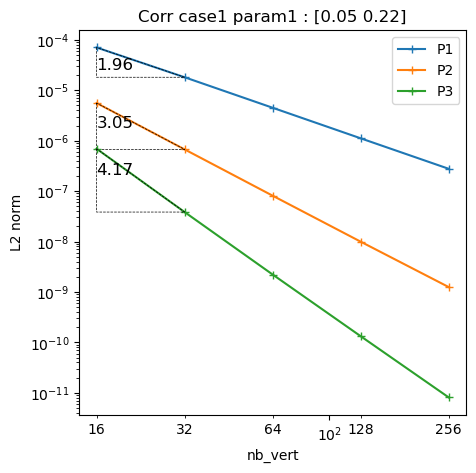

In [44]:
plt.figure(figsize=(5, 5))

# plot Corr error (L2 norm) as a function of h
for d in [1, 2, 3]:
    print(f"degree={d}")
    df_Corr, tab_nb_vert_Corr, tab_h_Corr, tab_err_Corr = run_Corr(d)
    plt.loglog(df_Corr['nb_vert'], df_Corr['err'], "+-", label='P'+str(d))
    
    slope, vert_mid = compute_slope(1,tab_nb_vert_Corr,tab_err_Corr)
    plt.text(vert_mid[0]+1e-2 , vert_mid[1], str(slope), fontsize=12, ha='left', va='top')

plt.xticks(df_Corr['nb_vert'], df_Corr['nb_vert'].round(3).astype(str), minor=True)
plt.xlabel("nb_vert")
plt.ylabel('L2 norm')
plt.legend()
plt.title(f'Corr case{testcase} param{param_num} : {param}')
plt.savefig(result_dir+f'Corr_case{testcase}_param{param_num}.png')

In [17]:
dict = {}
for d in [1, 2, 3]:
    print(f"degree={d}")
    _, tab_nb_vert_Corr, _, tab_err_Corr = run_Corr(d)
    if d == 1:
        dict['N'] = tab_nb_vert_Corr
    dict[f'P{d}'] = tab_err_Corr
    
df_deg_Corr = pd.DataFrame(dict)

csv_file = result_dir+f'Corr_case{testcase}_param{param_num}.csv'
df_deg_Corr.to_csv(csv_file, index=False)

degree=1
Read csv file ../../../results/fenics/test_2D/testcase1/version4/cvg/Corr_case1_param1_degree1.csv
degree=2
Read csv file ../../../results/fenics/test_2D/testcase1/version4/cvg/Corr_case1_param1_degree2.csv
degree=3
Read csv file ../../../results/fenics/test_2D/testcase1/version4/cvg/Corr_case1_param1_degree3.csv


## Plots

degree=1
Read csv file ../../../results/fenics/test_2D/testcase1/version4/cvg/FEM_case1_param1_degree1.csv
degree=2
Read csv file ../../../results/fenics/test_2D/testcase1/version4/cvg/FEM_case1_param1_degree2.csv
degree=3
Read csv file ../../../results/fenics/test_2D/testcase1/version4/cvg/FEM_case1_param1_degree3.csv
degree=1
Read csv file ../../../results/fenics/test_2D/testcase1/version4/cvg/Corr_case1_param1_degree1.csv
degree=2
Read csv file ../../../results/fenics/test_2D/testcase1/version4/cvg/Corr_case1_param1_degree2.csv
degree=3
Read csv file ../../../results/fenics/test_2D/testcase1/version4/cvg/Corr_case1_param1_degree3.csv


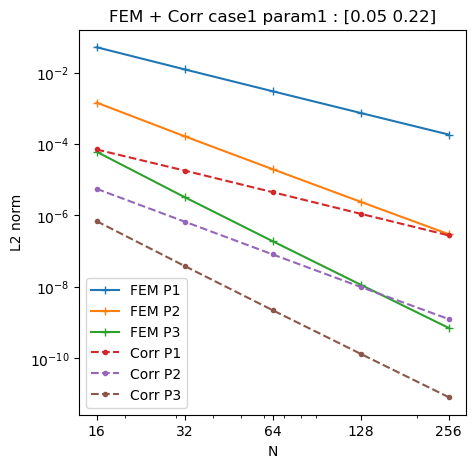

In [45]:
plt.figure(figsize=(5, 5))

# plot FEM error (L2 norm) as a function of h
for d in [1, 2, 3]:
    print(f"degree={d}")
    df_FEM, tab_nb_vert_FEM, tab_h_FEM, tab_err_FEM = run_FEM(d)
    plt.loglog(df_FEM['nb_vert'], df_FEM['err'], "+-", label='FEM P'+str(d))

# plot Corr error (L2 norm) as a function of h
for d in [1, 2, 3]:
    print(f"degree={d}")
    df_Corr,tab_nb_vert_Corr, tab_h_Corr, tab_err_Corr = run_Corr(d)
    plt.loglog(df_Corr['nb_vert'], df_Corr['err'], ".--", label='Corr P'+str(d))

plt.xticks(df_Corr['nb_vert'], df_Corr['nb_vert'].round(3).astype(str), minor=False)
plt.xlabel("N")
plt.ylabel('L2 norm')
plt.legend()
plt.title(f'FEM + Corr case{testcase} param{param_num} : {param}')
plt.savefig(result_dir+f'FEM-Corr_case{testcase}_param{param_num}.png')